## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from string import punctuation
import re
import nltk
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall
from keras.layers import Dense , Embedding , Bidirectional , LSTM, Conv1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers, initializers, Input, Model, callbacks






In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls 'drive/My Drive/zum/praca_domowa nlp/'

 Cell_Phones_and_Accessories_5.json   NLP_praca_domowa.ipynb
 glove.6B.100d.txt		     'Praca domowa v2.ipynb'


In [4]:
df = pd.read_json("/content/drive/My Drive/zum/praca_domowa nlp/Cell_Phones_and_Accessories_5.json", lines = True)

In [5]:
df.columns


Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [6]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [7]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      3519
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [8]:
df['reviewText'].head()

0    They look good and stick good! I just don't li...
1    These stickers work like the review says they ...
2    These are awesome and make my phone look so st...
3    Item arrived in great time and was in perfect ...
4    awesome! stays on, and looks great. can be use...
Name: reviewText, dtype: object

In [9]:
df['review_length'] = [len(text.split()) for text in df.reviewText]


In [10]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_length
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014",37
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014",32
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014",34
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013",51
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013",23


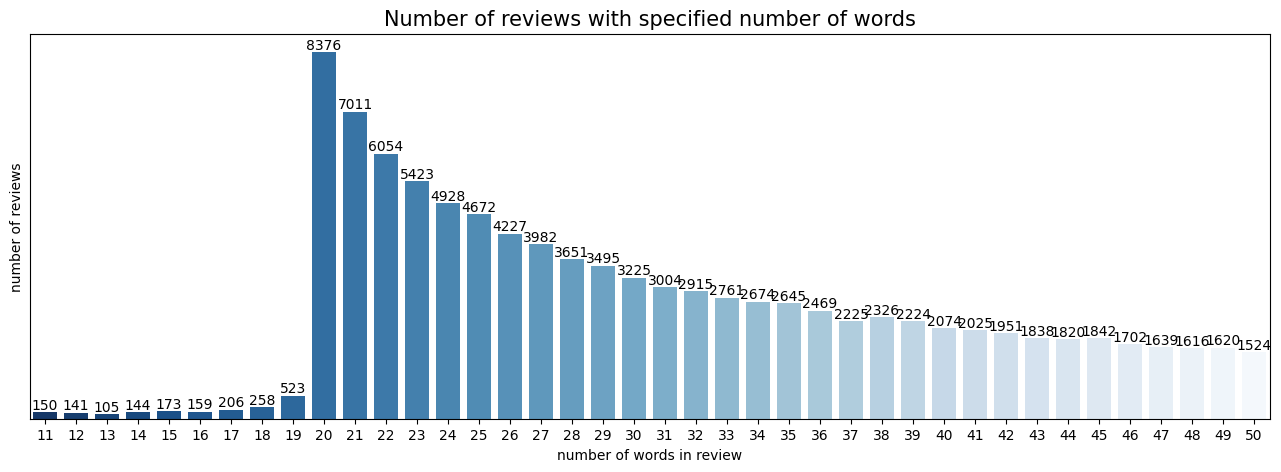

In [11]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='review_length', data=df[(df['review_length']<=50) & (df['review_length']>10)], palette='Blues_r')
plt.title('Number of reviews with specified number of words', fontsize=15)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('number of reviews')
plt.xlabel('number of words in review')
plt.show()

In [12]:
df = df[~(df['review_length'] < 20) & ~(df['review_length'] > 45)]


In [13]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_length
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014",37
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014",32
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014",34
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013",23
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1381536000,"10 12, 2013",23


In [ ]:
#rows_to_drop = int(0.6 * len(df))
#rows_indices_to_drop = df.sample(n=rows_to_drop, random_state=42).index
#df = df.drop(index=rows_indices_to_drop)



In [14]:
lemmatizer = WordNetLemmatizer()


In [15]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    else:
        return ''

def clean_rest(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)

    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]

    words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
df['reviewText'] = df['reviewText'].apply(clean_rest)


In [18]:
all_text = ''.join(df['reviewText'].values)
words = all_text.split()
word_counts = Counter(words)
top_words = word_counts.most_common(40)



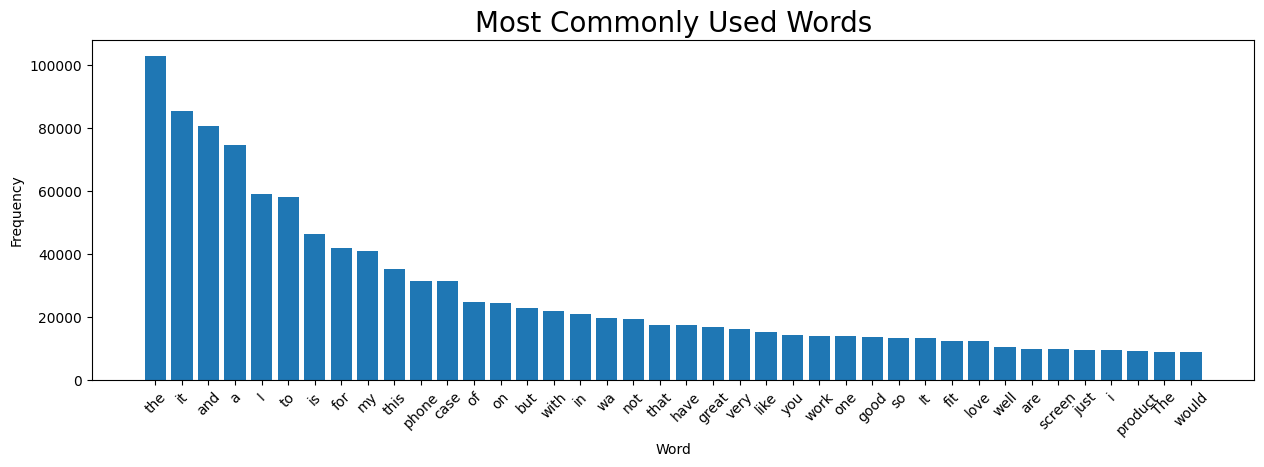

In [19]:

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(15,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=20)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.2)
plt.show()

In [20]:
df['reviewText'] = df['reviewText'].apply(remove_stopwords)
df['reviewText'] = df['reviewText'].apply(lambda x: x.lower())


In [21]:
all_text = ''.join(df['reviewText'].values)
words = all_text.split()
word_counts = Counter(words)
top_words = word_counts.most_common(40)

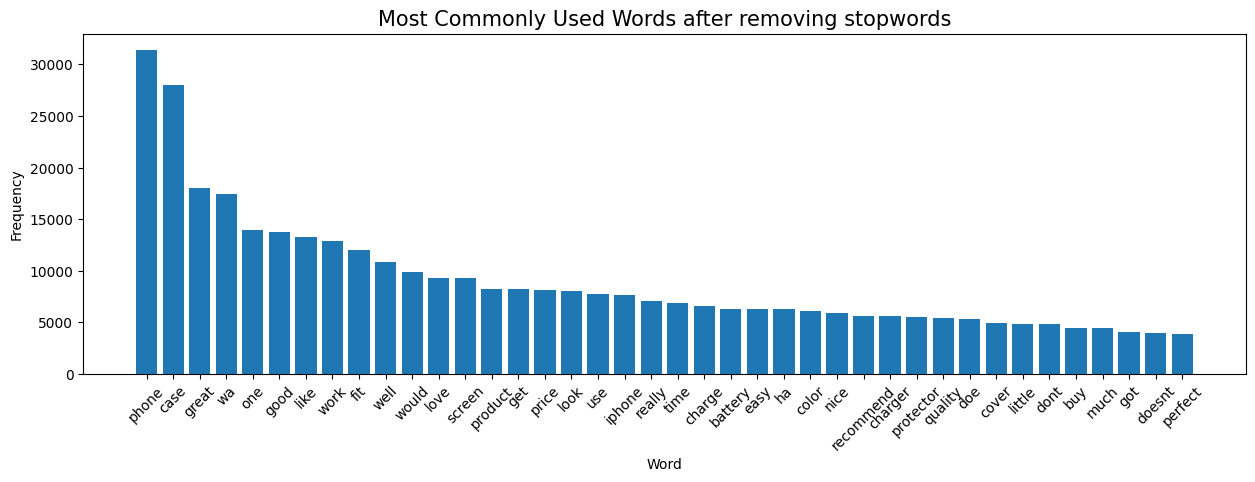

In [22]:
xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(15,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words after removing stopwords', fontsize=15)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.2)
plt.show()

In [23]:
df['reviewText'].head()

0    look good stick good dont like rounded shape w...
1    sticker work like review say stick great stay ...
2    awesome make phone look stylish used one far a...
4    awesome stay look great used multiple apple pr...
5    make using home button easy daughter like woul...
Name: reviewText, dtype: object

In [24]:
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful','summary', 'unixReviewTime', 'reviewTime'],axis='columns',inplace=True)

In [25]:
df.head()

,reviewText,overall,review_length
0,look good stick good dont like rounded shape w...,4,37
1,sticker work like review say stick great stay ...,5,32
2,awesome make phone look stylish used one far a...,5,34
4,awesome stay look great used multiple apple pr...,5,23
5,make using home button easy daughter like woul...,3,23


In [26]:

df['end_reviews'] = df['reviewText']


In [27]:
df.head()

,reviewText,overall,review_length,end_reviews
0,look good stick good dont like rounded shape w...,4,37,look good stick good dont like rounded shape w...
1,sticker work like review say stick great stay ...,5,32,sticker work like review say stick great stay ...
2,awesome make phone look stylish used one far a...,5,34,awesome make phone look stylish used one far a...
4,awesome stay look great used multiple apple pr...,5,23,awesome stay look great used multiple apple pr...
5,make using home button easy daughter like woul...,3,23,make using home button easy daughter like woul...


In [28]:
df.drop(['reviewText'],axis='columns',inplace=True)

In [29]:
df.head()

,overall,review_length,end_reviews
0,4,37,look good stick good dont like rounded shape w...
1,5,32,sticker work like review say stick great stay ...
2,5,34,awesome make phone look stylish used one far a...
4,5,23,awesome stay look great used multiple apple pr...
5,3,23,make using home button easy daughter like woul...


In [30]:
def convert_overall(df) :
    if df['overall'] <= 3.0 :
        rate = 0
    else :
        rate = 1

    return rate

In [31]:
df['overall'] = df.apply(convert_overall , axis = 1)


In [32]:
df.head()

,overall,review_length,end_reviews
0,1,37,look good stick good dont like rounded shape w...
1,1,32,sticker work like review say stick great stay ...
2,1,34,awesome make phone look stylish used one far a...
4,1,23,awesome stay look great used multiple apple pr...
5,0,23,make using home button easy daughter like woul...


In [33]:
dup = int(df["end_reviews"].duplicated().sum())

print("There are",dup,"duplicates")

There are 120 duplicates


In [34]:
df.drop_duplicates("end_reviews", inplace=True)


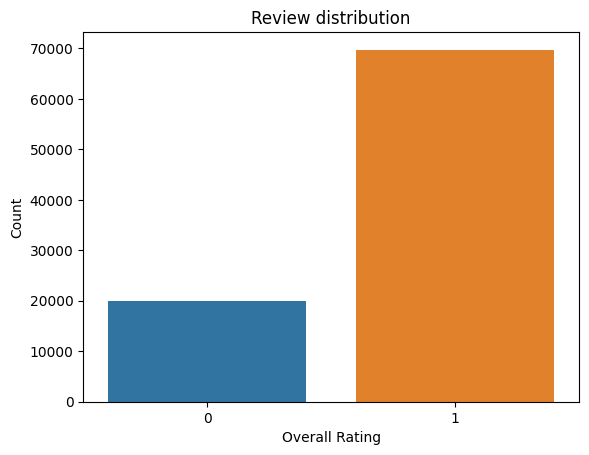

In [35]:
sns.countplot(x='overall', data=df)
plt.title('Review distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

In [36]:
x_train , x_val , y_train , y_val = train_test_split(df['end_reviews'], df['overall'], train_size = 0.8, random_state = 15)

In [37]:
len(x_train) , len(x_val)


(71773, 17944)

In [38]:
corpus = [word for text in df['end_reviews'] for word in text.split()]
words_count = Counter(corpus)
sorted_words = words_count.most_common()


In [39]:
vocab_size = len(sorted_words)
embedding_dim = 300
max_len = np.max(df['review_length'])

In [40]:
def vectorization(row_data) :
    tokenizer = Tokenizer(num_words=vocab_size , oov_token='<OOV>')
    tokenizer.fit_on_texts(row_data)
    seqs = tokenizer.texts_to_sequences(row_data)
    pad_seqs = pad_sequences(seqs , maxlen = max_len , padding='post')

    return pad_seqs

In [41]:
x_train, x_val

(100996            took get low cost complain work great far
 85181     work like original pink bought pink charger go...
 70613     love fit case iv bought many like love price p...
 122754    really easy put used credit card wont give bub...
 87413     nice handy helpful stylus pen gave friend used...
                                 ...                        
 99494     got case today already love sleek case still f...
 137969    protects screen seems tiny bit small minor iss...
 19270     real complaint case doesnt fall apart snug fit...
 106247    phone run slowly even ha core many laggs using...
 18325     improvement part holding part horizontal adjus...
 Name: end_reviews, Length: 71773, dtype: object,
 35133     son like cover case color thought would think ...
 343       fit make sure ordering right one need tool sug...
 84144     throw away didnt fit mine one else know phone ...
 89546     put first ha stickiness screen protector day f...
 27093     good nothing magical exa

In [42]:
x_train = vectorization(x_train)
x_val = vectorization(x_val)

In [43]:
x_train, x_val

(array([[ 208,   18,  335, ...,    0,    0,    0],
        [  10,    8,  137, ...,    0,    0,    0],
        [   9,   11,    3, ...,    0,    0,    0],
        ...,
        [ 272,  217,    3, ...,    0,    0,    0],
        [   2,  583, 1494, ...,    0,    0,    0],
        [1488,  198,  456, ...,    0,    0,    0]], dtype=int32),
 array([[ 282,    8,   33, ...,    0,    0,    0],
        [  11,   54,  145, ...,    0,    0,    0],
        [1030,  237,   64, ...,    0,    0,    0],
        ...,
        [   9, 1882,   41, ...,    0,    0,    0],
        [  10,   21,   12, ...,    0,    0,    0],
        [  69,  173,   65, ...,    0,    0,    0]], dtype=int32))

In [44]:
model_lstm1 = Sequential()
model_lstm1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model_lstm1.add(Bidirectional(LSTM(256, return_sequences=True)))
model_lstm1.add(Bidirectional(LSTM(128)))
model_lstm1.add(Dense(64, activation='relu'))

model_lstm1.add(Dense(1, activation='sigmoid'))

model_lstm1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm1.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/10
561/561 [==============================] - 51s 73ms/step - loss: 0.3295 - accuracy: 0.8605 - val_loss: 0.6082 - val_accuracy: 0.7438
Epoch 2/10
561/561 [==============================] - 24s 42ms/step - loss: 0.2543 - accuracy: 0.8966 - val_loss: 0.6561 - val_accuracy: 0.7227
Epoch 3/10
561/561 [==============================] - 22s 38ms/step - loss: 0.2113 - accuracy: 0.9154 - val_loss: 0.7648 - val_accuracy: 0.7321
Epoch 4/10
561/561 [==============================] - 22s 39ms/step - loss: 0.1727 - accuracy: 0.9320 - val_loss: 0.9066 - val_accuracy: 0.7306
Epoch 5/10
561/561 [==============================] - 22s 39ms/step - loss: 0.1429 - accuracy: 0.9440 - val_loss: 0.8345 - val_accuracy: 0.7148
Epoch 6/10
561/561 [==============================] - 21s 38ms/step - loss: 0.1156 - accuracy: 0.9561 - val_loss: 1.1067 - val_accuracy: 0.7170
Epoch 7/10
561/561 [==============================] - 22s 39ms/step - loss: 0.0924 - accuracy: 0.9654 - val_loss: 1.2665 - val_accuracy:

In [45]:

model_cnn1 = Sequential()
model_cnn1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model_cnn1.add(Conv1D(128, 5, activation='relu'))
model_cnn1.add(GlobalMaxPooling1D())

model_cnn1.add(Dense(1, activation='sigmoid'))

model_cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn1.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/10
561/561 [==============================] - 21s 33ms/step - loss: 0.3375 - accuracy: 0.8557 - val_loss: 0.6218 - val_accuracy: 0.7475
Epoch 2/10
561/561 [==============================] - 6s 11ms/step - loss: 0.2435 - accuracy: 0.9022 - val_loss: 0.6589 - val_accuracy: 0.7399
Epoch 3/10
561/561 [==============================] - 6s 11ms/step - loss: 0.1620 - accuracy: 0.9397 - val_loss: 0.7768 - val_accuracy: 0.7250
Epoch 4/10
561/561 [==============================] - 5s 10ms/step - loss: 0.0922 - accuracy: 0.9682 - val_loss: 0.9238 - val_accuracy: 0.7226
Epoch 5/10
561/561 [==============================] - 6s 10ms/step - loss: 0.0484 - accuracy: 0.9853 - val_loss: 1.1691 - val_accuracy: 0.7227
Epoch 6/10
561/561 [==============================] - 6s 10ms/step - loss: 0.0223 - accuracy: 0.9947 - val_loss: 1.3664 - val_accuracy: 0.7135
Epoch 7/10
561/561 [==============================] - 5s 9ms/step - loss: 0.0100 - accuracy: 0.9983 - val_loss: 1.5892 - val_accuracy: 0.6962

In [46]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_path = "/content/drive/My Drive/zum/praca_domowa nlp/glove.6B.100d.txt"
glove_embeddings = load_glove_embeddings(glove_path)

In [47]:
X_train_em , X_val_em , Y_train_em , Y_val_em = train_test_split(df['end_reviews'], df['overall'], train_size = 0.8, random_state = 45)

In [48]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_em)

X_train_sequences = tokenizer.texts_to_sequences(X_train_em)
X_val_sequences = tokenizer.texts_to_sequences(X_val_em)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(seq) for seq in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_len, padding='post')

In [49]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [50]:


model_em = Sequential()
model_em.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model_em.add(Bidirectional(LSTM(256, return_sequences=True)))
model_em.add(Bidirectional(LSTM(128)))
model_em.add(Dense(64, activation='relu'))
model_em.add(Dense(1, activation='sigmoid'))

model_em.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_em = model_em.fit(X_train_padded, Y_train_em, epochs=10, batch_size=32, validation_data=(X_val_padded, Y_val_em))

Epoch 1/10
2243/2243 [==============================] - 43s 16ms/step - loss: 0.3680 - accuracy: 0.8396 - val_loss: 0.3297 - val_accuracy: 0.8600
Epoch 2/10
2243/2243 [==============================] - 34s 15ms/step - loss: 0.3125 - accuracy: 0.8684 - val_loss: 0.3036 - val_accuracy: 0.8706
Epoch 3/10
2243/2243 [==============================] - 35s 16ms/step - loss: 0.2820 - accuracy: 0.8826 - val_loss: 0.2969 - val_accuracy: 0.8752
Epoch 4/10
2243/2243 [==============================] - 33s 15ms/step - loss: 0.2517 - accuracy: 0.8962 - val_loss: 0.2962 - val_accuracy: 0.8729
Epoch 5/10
2243/2243 [==============================] - 32s 14ms/step - loss: 0.2124 - accuracy: 0.9147 - val_loss: 0.3292 - val_accuracy: 0.8764
Epoch 6/10
2243/2243 [==============================] - 32s 14ms/step - loss: 0.1655 - accuracy: 0.9342 - val_loss: 0.3709 - val_accuracy: 0.8718
Epoch 7/10
2243/2243 [==============================] - 33s 15ms/step - loss: 0.1196 - accuracy: 0.9535 - val_loss: 0.4629 -

## For prediction I have used 1 star review from amazon filled last year so not included in csv. Should be negative




In [51]:


new_text = "Received phone in excellent condition. The one star is bc the phone recognized that we were trying to set it up on the AT&T network, but would not actually connect to the network. The phone would receive the text from AT&T to continue setup, but the phone would not move past the SOS function. The AT&T store rep could not resolve the problem and suggested I contact Amazon to troubleshoot. I mistakenly contacted Amazon instead of the 3rd party seller and they were less than helpful. I've been a Prime member for many years and never had a problem like I did this time. I contacted them to troubleshoot the problem, but automatically elected to send me a new phone. I was told the expected arrival was 2 weeks away and I was very upset about this due to the fact that I specifically ordered a prime item that I received within 3 days. Once my 2 week deadline was up the delivery date change to another 1.5 weeks. I called Amazon customer service back and was told there was nothing she could due and the product would be delivered to me ASAP. I then asked to speak to a supervisor and was told the same basic thing and that the delay was due to the 3rd party supplier not currently having the phone in stock. I asked to please have the product sent to me from a different seller and was basically told that they don't normally do that, but since I wasn't happy with the delivery time frame that she could help me find one from a different seller and have that sent instead. After a ton of explaining that I wanted the same product with the same renewed excellent rating and the amazon supervisor trying to send me a less than stellar product I elected to get a refund and place a new order myself."
if isinstance(new_text, str):
    cleaned_new_text = clean_rest(new_text)
    cleaned_new_text1 = remove_stopwords(cleaned_new_text)
    cleaned_new_text_lowercase = cleaned_new_text1.lower()

    print(f'Original: "{new_text}" - Cleaned: "{cleaned_new_text_lowercase}"')
else:
    print("Error: new_text is not a string.")

Original: "Received phone in excellent condition. The one star is bc the phone recognized that we were trying to set it up on the AT&T network, but would not actually connect to the network. The phone would receive the text from AT&T to continue setup, but the phone would not move past the SOS function. The AT&T store rep could not resolve the problem and suggested I contact Amazon to troubleshoot. I mistakenly contacted Amazon instead of the 3rd party seller and they were less than helpful. I've been a Prime member for many years and never had a problem like I did this time. I contacted them to troubleshoot the problem, but automatically elected to send me a new phone. I was told the expected arrival was 2 weeks away and I was very upset about this due to the fact that I specifically ordered a prime item that I received within 3 days. Once my 2 week deadline was up the delivery date change to another 1.5 weeks. I called Amazon customer service back and was told there was nothing she c

In [53]:
new_text_sequences = tokenizer.texts_to_sequences([cleaned_new_text_lowercase])
new_text_padded = pad_sequences(new_text_sequences, maxlen=max_len, padding='post')

predictions = model_em.predict(new_text_padded)

binary_predictions = (predictions > 0.5).astype(int)

sentiment = "Positive" if binary_predictions[0] == 1 else "Negative"
print(f'Predicted Sentiment: {sentiment}')

1/1 [==============================] - 0s 79ms/step
Predicted Sentiment: Negative


In [54]:
X_train_ft , X_val_ft , Y_train_ft , Y_val_ft = train_test_split(df['end_reviews'], df['overall'], train_size = 0.8, random_state = 45)

In [55]:
from fastai.text.all import *

train_df = pd.DataFrame({'text': X_train_ft.tolist(), 'label': Y_train_ft})
valid_df = pd.DataFrame({'text': X_val_ft.tolist(), 'label': Y_val_ft})

db_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)
)


In [56]:
dls_lm = db_lm.dataloaders(train_df)

dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos wife love make quite happy protects iphone look good keep happy xxbos case product broke one day waiting year get purchase item xxbos stated much like play around change cell phone xxunk phone bling one smaller one enjoy xxbos charger work like charm stand phone night stand perfectly used bedside alarm clock recommend highly blackberry bold xxbos item really nice nice color great price item arriving earlier said time plus little,wife love make quite happy protects iphone look good keep happy xxbos case product broke one day waiting year get purchase item xxbos stated much like play around change cell phone xxunk phone bling one smaller one enjoy xxbos charger work like charm stand phone night stand perfectly used bedside alarm clock recommend highly blackberry bold xxbos item really nice nice color great price item arriving earlier said time plus little hard
1,small scuff xxunk well worth you re like hate bulky case xxbos great case ordering guy year always amazing tpu case miss day included premium screen protector free xxbos hey usb cable either work does nt work also ha solid feeling plugged xxbos daughter liked panda case iphone cute got alot compliment xxbos perfect placing dash window note fit perfectly well husband iphone ca nt go wrong good price good quality product,scuff xxunk well worth you re like hate bulky case xxbos great case ordering guy year always amazing tpu case miss day included premium screen protector free xxbos hey usb cable either work does nt work also ha solid feeling plugged xxbos daughter liked panda case iphone cute got alot compliment xxbos perfect placing dash window note fit perfectly well husband iphone ca nt go wrong good price good quality product xxbos


In [57]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Perplexity()])

learn.fine_tune(1, 1e-2)

learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.808321,5.518844,0.148671,249.346664,01:24


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.267984,5.224309,0.172134,185.732773,01:37


In [58]:
!ls 'models'


fine_tuned_enc.pth


In [59]:
encoder_path_full = 'models/fine_tuned_enc.pth'
encoder_path = 'fine_tuned_enc'
encoder = torch.load(encoder_path_full)

sa_train_df = pd.DataFrame({'text': X_train_ft.tolist(), 'label': Y_train_ft})
sa_valid_df = pd.DataFrame({'text': X_val_ft.tolist(), 'label': Y_val_ft})

db_sa = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)
)

dls_sa = db_sa.dataloaders(sa_train_df)

learn_sa = text_classifier_learner(dls_sa, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])

learn_sa = learn_sa.load_encoder(encoder_path)

learn_sa.fine_tune(1, 1e-2)

learn_sa.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,0.398444,0.362419,0.837537,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.321901,0.298281,0.873903,01:40


,text,category,category_
0,xxbos case broke wa installing get xxunk nonslip spigen samsung galaxy note case slim ultra fit smooth black rubbery feel nonslip grip matte hard case galaxy note xxrep 3 i xxunk packaging smooth black sgp case instead,0,1
1,xxbos dirty screen non working proximity detector faulty ear piece item arrived one day late defective dirty box dirty screen non working proximity detector faulty ear piece item arrived one day late defective dirty box,0,0
2,xxbos awesome dock work advertised well worth price recent app update ibolt wa buggy leaving review play store app xxunk immediately released update bug awesome support manufacturer take care issue would buy,1,1
3,xxbos power two v accessory time fit type european american japanese xxunk heavyduty requirement device ipad mobile phone gps xxunk car power source led indicator output voltage v output current maximum,1,1
4,xxbos headphone incredible bass well suited ear sound perfect happy xxunk xxunk xxunk xxunk xxunk xxunk se xxunk bien la xxunk el xxunk e perfecto estoy muy xxunk con xxunk compra,1,1
5,xxbos old ios charger adapter allows spare charger new ios lightning xxunk does nt allow transfer content ie does nt work ipad photo xxunk price good value compared brand device,0,1
6,xxbos tested last week love feature owned samsung galaxy fit smartphone iphone g like replace iphone g soon may consider samsung galaxy case apple ca nt come bigger screen iphone,1,1
7,xxbos handsdown favorite iphone case thin lightweight unobtrusive soft touch feel nice give good grip perfect iphone case you re looking minimal scratch protection yet want maintain sleek look phone,1,1
8,xxbos i m using wife iphone white wanted case enhance white color new phone case provides good protection case accidental drop made good quality material additionally look great white iphone,1,1
